Goal:
    
* Summarize code using new probability update scheme
* Tune parameter using manual dissaggregation method
* Run on all data to examine problems
* Integrate into Viberbi method
* Design proper API for the disaggregation package
    
    

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import datetime

# 1. Summarize code using new probability update scheme


In [2]:
# Code is summarized in energyanalytics/disaggregation/bayesian_cp_detect/bayesian_cp_2.py
# Code basically adapted from Notebook 20160829-20160904
# I will make sure it is still working using data from Apr 1st, 2016, as used in the last notebook

In [2]:
import json

with open('../metadata/cluster result.json', 'r') as fid:
    var = json.load(fid)
    
cluster_mean = [np.array(t) for t in var]
n_clusters = len(cluster_mean)

In [3]:
import sys

mod_path = '/Users/bh56/Dropbox/Equota/energyanalytics/disaggregation'
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)

from bayesian_cp_detect import bayesian_cp_2 as bcp
# from bayesian_cp_2 import *

ImportError: No module named bayesian_cp_detect

In [69]:
# make sure that the code is loaded to the lastest version
reload(bcp)

<module 'bayesian_cp_detect.bayesian_cp_2' from '/Users/bh56/Dropbox/Equota/energyanalytics/disaggregation/bayesian_cp_detect/bayesian_cp_2.py'>

In [5]:
def plot_24h_data(t, raw_data, data, cp_list):
    fig, axes = plt.subplots(nrows=4, figsize=[18, 10])
    
    for i, ax in enumerate(axes):
        ax.plot(t, data, 'r-', markersize=3, linewidth=1, label='smooth')
        ax.plot(t, raw_data, 'k.', markersize=3, label='raw')
        
        for cp in cp_list:
            ax.plot([t[cp], t[cp]], [0, 400], 'k-', linewidth=1)
        ax.set_ylabel('power')
        ax.set_xlim([0+i*6,6+i*6])
    ax.set_xlabel('time/h')
    plt.legend()

In [6]:
# %%time
reload(bcp)
t, raw_data = bcp.read_dat_0819(datetime.date(2016,4,1), 0, 24, '../new_data/IHG')
_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

print 'size of data: %d' % len(data)

para = {}

para['delta_init'] = [float(200/3), float(200/3), float(400/3), float(400/3)]
para['H'] = np.log(1-1./(15*4)) # 15 min per cp

para['Q'] = float(10) # process error
para['R'] = float(200) # measurement error
para['shape'] = [cluster_mean[i] for i in [0,1,4,5]]
para['n_shape'] = len(para['shape'])
para['delta_shape'] = [float(50/3) for _ in range(para['n_shape'])]

para['unhappy_count_thre'] = 10
para['len_protected'] = 5

cp_list = bcp.disaggregate(data, para)

print 'all cp(s): ', cp_list

NameError: name 'bcp' is not defined

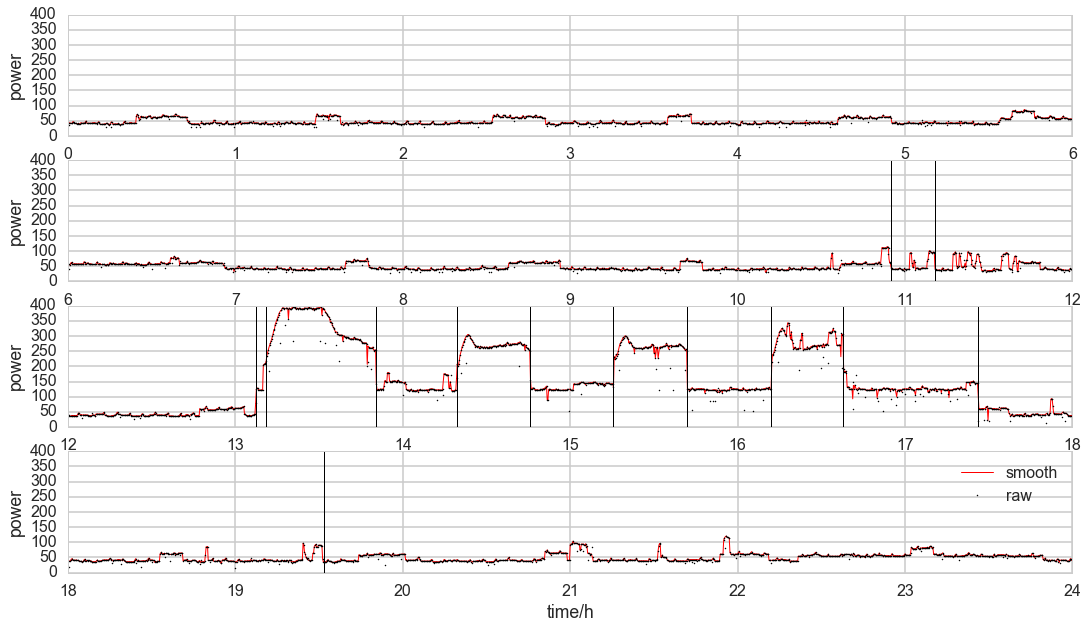

In [141]:
plot_24h_data(t, raw_data, data, cp_list)

# 2. Tune parameter using manual dissaggregation method

In [142]:
with open('../results/4_1_manual_seg.txt', 'r') as fid:
    manual_cp_list = [int(float(t.strip())) for t in  fid.readlines()]
print manual_cp_list, len(manual_cp_list)

[3149, 3322, 3437, 3543, 3663, 3768, 3889, 3992, 4185] 9


In [143]:
print cp_list, len(cp_list)

[0, 2620, 2683, 3149, 3164, 3321, 3437, 3542, 3662, 3767, 3888, 3991, 4185, 4687] 14


In [144]:
def cp_list_diff(list_1, list_2):
    list_1 = [t for t in list_1 if t > 100]
    counter_wrong = 0
    counter_miss = 0
    for cp in list_1:
        counter_wrong += 1 if len([1 for t in list_2 if t >=cp-1 and t <= cp+1]) == 0 else 0
    for cp in list_2:
        counter_miss += 1 if len([1 for t in list_1 if t >=cp-1 and t <= cp+1]) == 0 else 0
    return counter_wrong, counter_miss

counter_wrong, counter_miss = cp_list_diff(cp_list, manual_cp_list)
counter_wrong, counter_miss

(4, 0)

In [145]:
%time
for Q in [10, 40, 160]:
    for R in [50, 200, 800]:
        for unhappy_count_thre in [5, 10]:
            for len_protected in [5, 10]:
                for delta_init_1 in [float(50/3), float(200/3)]:
                    for delta_init_2 in [float(100/3), float(400/3)]:
                        para = {}

                        para['delta_init'] = [delta_init_1, delta_init_1, delta_init_2, delta_init_2]
                        para['H'] = np.log(1-1./(15*4)) # 15 min per cp

                        para['Q'] = float(Q) # process error
                        para['R'] = float(R) # measurement error
                        para['shape'] = [cluster_mean[i] for i in [0,1,4,5]]
                        para['n_shape'] = len(para['shape'])
                        para['delta_shape'] = [float(50/3) for _ in range(para['n_shape'])]

                        para['unhappy_count_thre'] = unhappy_count_thre
                        para['len_protected'] = len_protected

                        cp_list = bcp.disaggregate(data, para)
                        counter_wrong, counter_miss = cp_list_diff(cp_list, manual_cp_list)
                        print Q, R, unhappy_count_thre, len_protected, delta_init_1, delta_init_2, (counter_wrong, counter_miss)
                

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
10 50 5 5 16.0 33.0 (11, 1)
10 50 5 5 16.0 133.0 (17, 1)
10 50 5 5 66.0 33.0 (17, 1)
10 50 5 5 66.0 133.0 (20, 1)
10 50 5 10 16.0 33.0 (10, 1)
10 50 5 10 16.0 133.0 (16, 1)
10 50 5 10 66.0 33.0 (15, 1)
10 50 5 10 66.0 133.0 (19, 1)
10 50 10 5 16.0 33.0 (3, 1)
10 50 10 5 16.0 133.0 (9, 1)
10 50 10 5 66.0 33.0 (3, 1)
10 50 10 5 66.0 133.0 (11, 1)
10 50 10 10 16.0 33.0 (3, 1)
10 50 10 10 16.0 133.0 (9, 1)
10 50 10 10 66.0 33.0 (3, 1)
10 50 10 10 66.0 133.0 (11, 1)
10 200 5 5 16.0 33.0 (5, 0)
10 200 5 5 16.0 133.0 (9, 0)
10 200 5 5 66.0 33.0 (9, 0)
10 200 5 5 66.0 133.0 (12, 0)
10 200 5 10 16.0 33.0 (5, 0)
10 200 5 10 16.0 133.0 (10, 0)
10 200 5 10 66.0 33.0 (9, 0)
10 200 5 10 66.0 133.0 (13, 0)
10 200 10 5 16.0 33.0 (1, 0)
10 200 10 5 16.0 133.0 (4, 0)
10 200 10 5 66.0 33.0 (1, 0)
10 200 10 5 66.0 133.0 (4, 0)
10 200 10 10 16.0 33.0 (1, 0)
10 200 10 10 16.0 133.0 (4, 0)
10 200 10 10 66.0 33.0 (1, 0)
10 200 10 10 66.0 133.0 (4

In [136]:
%%time
t, raw_data = bcp.read_dat_0819(datetime.date(2016,4,2), 0, 24, '../new_data/IHG')
_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

print 'size of data: %d' % len(data)

para = {}

para['delta_init'] = [float(200/3), float(200/3), float(400/3), float(400/3)]
para['H'] = np.log(1-1./(15*4)) # 15 min per cp

para['Q'] = float(10) # process error
para['R'] = float(200) # measurement error
para['shape'] = [cluster_mean[i] for i in [0,1,4,5]]
para['n_shape'] = len(para['shape'])
para['delta_shape'] = [float(50/3) for _ in range(para['n_shape'])]

para['unhappy_count_thre'] = 10
para['len_protected'] = 5

cp_list = bcp.disaggregate(data, para)

print 'all cp(s): ', cp_list

size of data: 5760
all cp(s):  [0, 3244, 3409, 3431, 3550, 3570, 3654, 3786, 3886, 4021, 4121, 4264, 4289, 4330, 4362, 4412, 4439, 4495, 4515, 4576, 4603, 4656, 4673, 4686, 4741, 4767, 4816, 4846, 4904, 4929, 4985, 5011, 5033, 5052, 5065]
CPU times: user 4.98 s, sys: 116 ms, total: 5.1 s
Wall time: 5.05 s


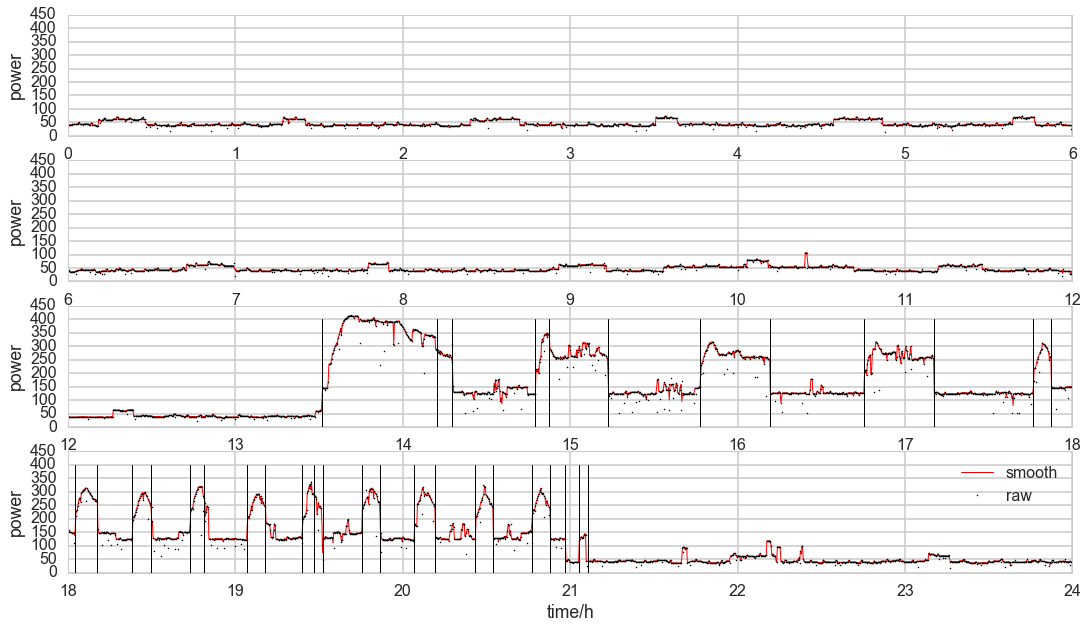

In [137]:
plot_24h_data(t, raw_data, data, cp_list)

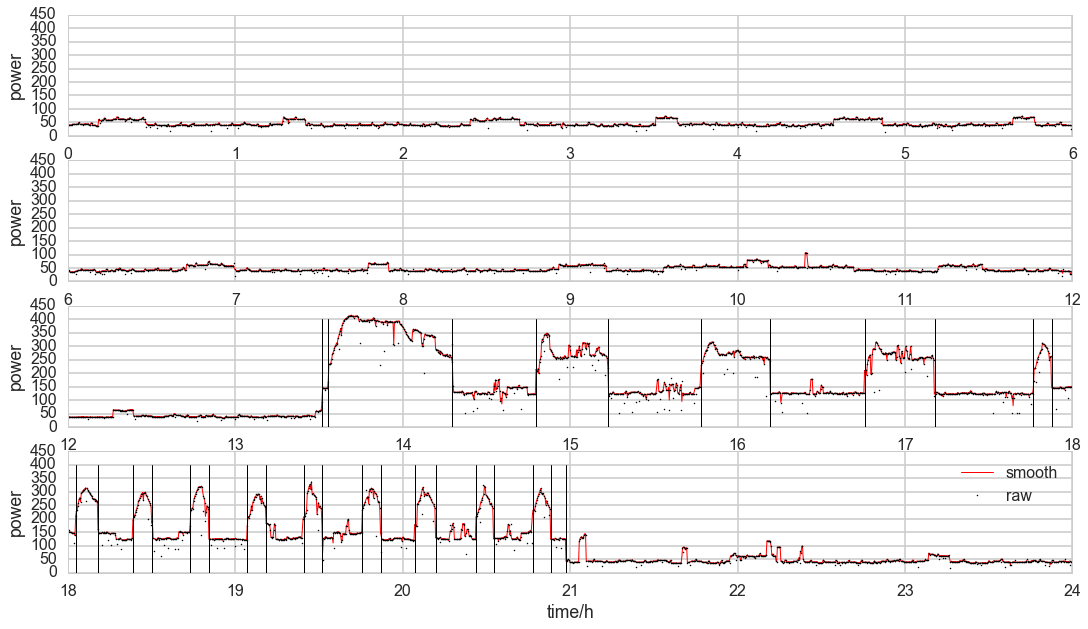

In [138]:
plot_24h_data(t, raw_data, data, manual_cp_list)

In [132]:
with open('../results/4_2_manual_seg.txt', 'r') as fid:
    manual_cp_list = [int(float(t.strip())) for t in  fid.readlines()]
print manual_cp_list, len(manual_cp_list)
counter_wrong, counter_miss = cp_list_diff(cp_list, manual_cp_list)
counter_wrong, counter_miss

[3244, 3253, 3431, 3551, 3654, 3787, 3887, 4022, 4123, 4264, 4290, 4331, 4363, 4413, 4441, 4495, 4522, 4577, 4604, 4658, 4684, 4742, 4768, 4817, 4847, 4905, 4930, 4986, 5012, 5034] 30


(10, 6)

In [139]:
for Q in [10, 40, 160]:
    for R in [50, 200, 800]:
        for unhappy_count_thre in [5, 10]:
            for len_protected in [5, 10]:
                for delta_init_1 in [float(50/3), float(200/3)]:
                    for delta_init_2 in [float(100/3), float(400/3)]:
                        para = {}

                        para['delta_init'] = [delta_init_1, delta_init_1, delta_init_2, delta_init_2]
                        para['H'] = np.log(1-1./(15*4)) # 15 min per cp

                        para['Q'] = float(Q) # process error
                        para['R'] = float(R) # measurement error
                        para['shape'] = [cluster_mean[i] for i in [0,1,4,5]]
                        para['n_shape'] = len(para['shape'])
                        para['delta_shape'] = [float(50/3) for _ in range(para['n_shape'])]

                        para['unhappy_count_thre'] = unhappy_count_thre
                        para['len_protected'] = len_protected

                        cp_list = bcp.disaggregate(data, para)
                        counter_wrong, counter_miss = cp_list_diff(cp_list, manual_cp_list)
                        print Q, R, unhappy_count_thre, len_protected, delta_init_1, delta_init_2, (counter_wrong, counter_miss)
                

10 50 5 5 16.0 33.0 (16, 4)
10 50 5 5 16.0 133.0 (24, 5)
10 50 5 5 66.0 33.0 (16, 4)
10 50 5 5 66.0 133.0 (24, 5)
10 50 5 10 16.0 33.0 (15, 4)
10 50 5 10 16.0 133.0 (25, 5)
10 50 5 10 66.0 33.0 (15, 4)
10 50 5 10 66.0 133.0 (25, 5)
10 50 10 5 16.0 33.0 (11, 6)
10 50 10 5 16.0 133.0 (22, 7)
10 50 10 5 66.0 33.0 (11, 6)
10 50 10 5 66.0 133.0 (22, 7)
10 50 10 10 16.0 33.0 (11, 5)
10 50 10 10 16.0 133.0 (19, 6)
10 50 10 10 66.0 33.0 (11, 5)
10 50 10 10 66.0 133.0 (19, 6)
10 200 5 5 16.0 33.0 (13, 3)
10 200 5 5 16.0 133.0 (16, 4)
10 200 5 5 66.0 33.0 (13, 3)
10 200 5 5 66.0 133.0 (16, 4)
10 200 5 10 16.0 33.0 (14, 3)
10 200 5 10 16.0 133.0 (17, 4)
10 200 5 10 66.0 33.0 (14, 3)
10 200 5 10 66.0 133.0 (17, 4)
10 200 10 5 16.0 33.0 (7, 5)
10 200 10 5 16.0 133.0 (9, 6)
10 200 10 5 66.0 33.0 (7, 5)
10 200 10 5 66.0 133.0 (10, 6)
10 200 10 10 16.0 33.0 (5, 4)
10 200 10 10 16.0 133.0 (8, 5)
10 200 10 10 66.0 33.0 (5, 4)
10 200 10 10 66.0 133.0 (8, 5)
10 800 5 5 16.0 33.0 (6, 3)
10 800 5 5 16.0 133

In [153]:
para = {}

para['delta_init'] = [float(200/3), float(200/3), float(400/3), float(400/3)]
para['H'] = np.log(1-1./(15*4)) # 15 min per cp

para['Q'] = float(10) # process error
para['R'] = float(800) # measurement error
para['shape'] = [cluster_mean[i] for i in [0,1,4,5]]
para['n_shape'] = len(para['shape'])
para['delta_shape'] = [float(50/3) for _ in range(para['n_shape'])]

para['unhappy_count_thre'] = 5
para['len_protected'] = 5


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
[0, 3149, 3321, 3437, 3542, 3662, 3767, 3888, 3991, 4185, 5260, 5268]


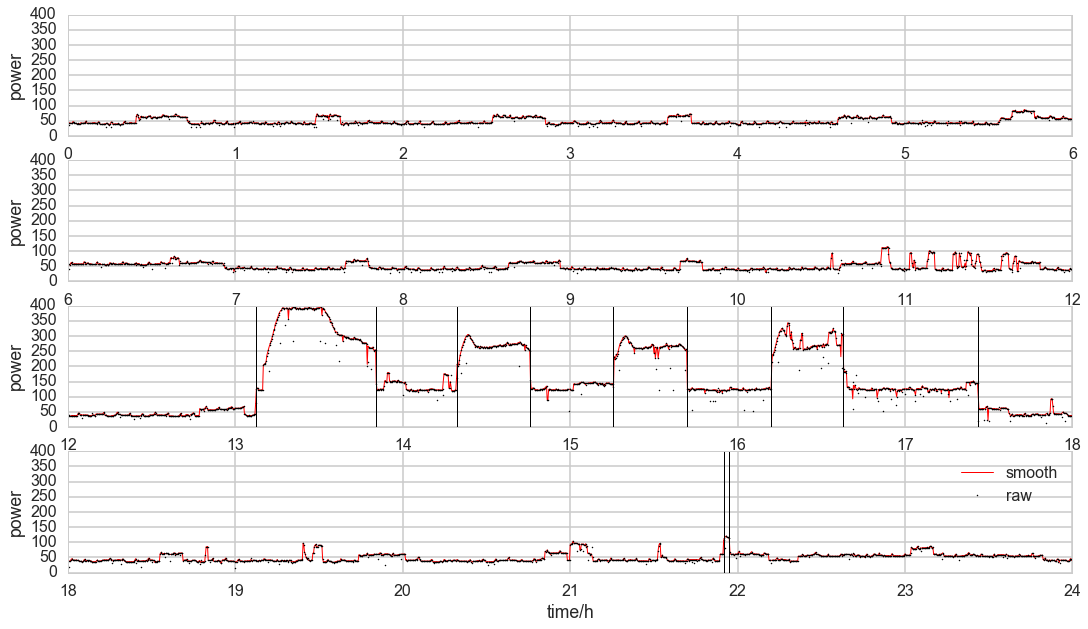

In [160]:
%time
t, raw_data = bcp.read_dat_0819(datetime.date(2016,4,1), 0, 24, '../new_data/IHG')
_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

cp_list = bcp.disaggregate(data, para)
plot_24h_data(t, raw_data, data, cp_list)

print cp_list

[0, 3244, 3431, 3550, 3559, 3570, 3654, 3787, 3886, 4021, 4121, 4264, 4289, 4331, 4362, 4413, 4440, 4495, 4521, 4577, 4604, 4657, 4684, 4741, 4767, 4820, 4846, 4905, 4929, 4985, 5011, 5033, 5052, 5062]
CPU times: user 6.06 s, sys: 96.3 ms, total: 6.16 s
Wall time: 6.44 s


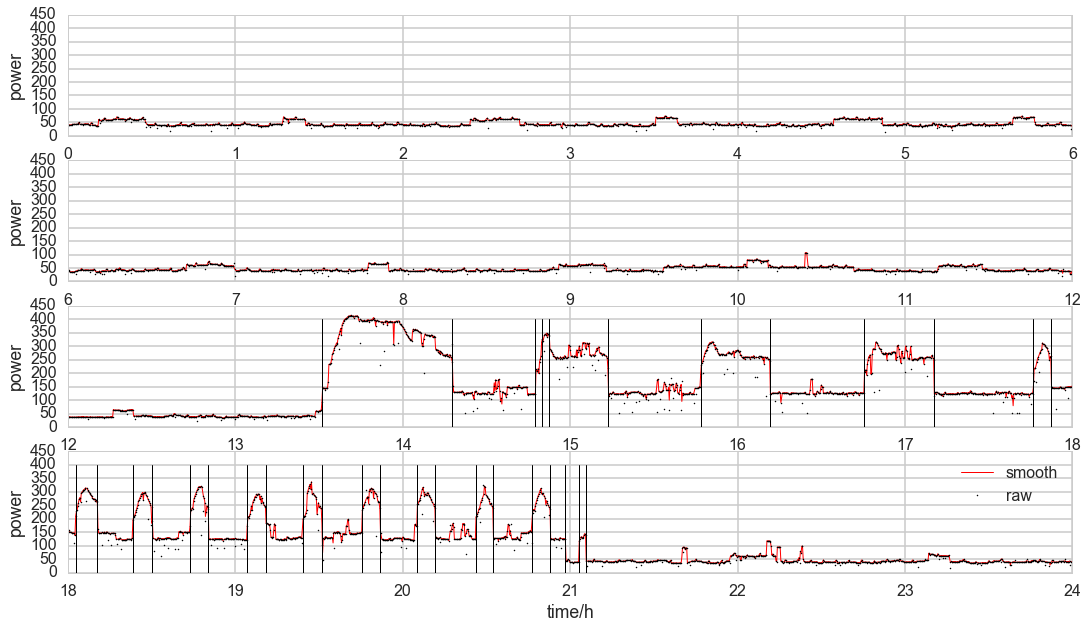

In [175]:
%%time
t, raw_data = bcp.read_dat_0819(datetime.date(2016,4,2), 0, 24, '../new_data/IHG')
_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

cp_list = bcp.disaggregate(data, para)
plot_24h_data(t, raw_data, data, cp_list)

print cp_list

[0, 2241, 2251, 2585, 2709, 2823, 2868, 3269, 3419, 3519, 3670, 3771, 3917, 4016, 4162, 4260, 4405, 4504, 4679, 4778, 4947, 5045, 5216, 5318, 5486, 5516]
CPU times: user 6.1 s, sys: 106 ms, total: 6.2 s
Wall time: 6.48 s


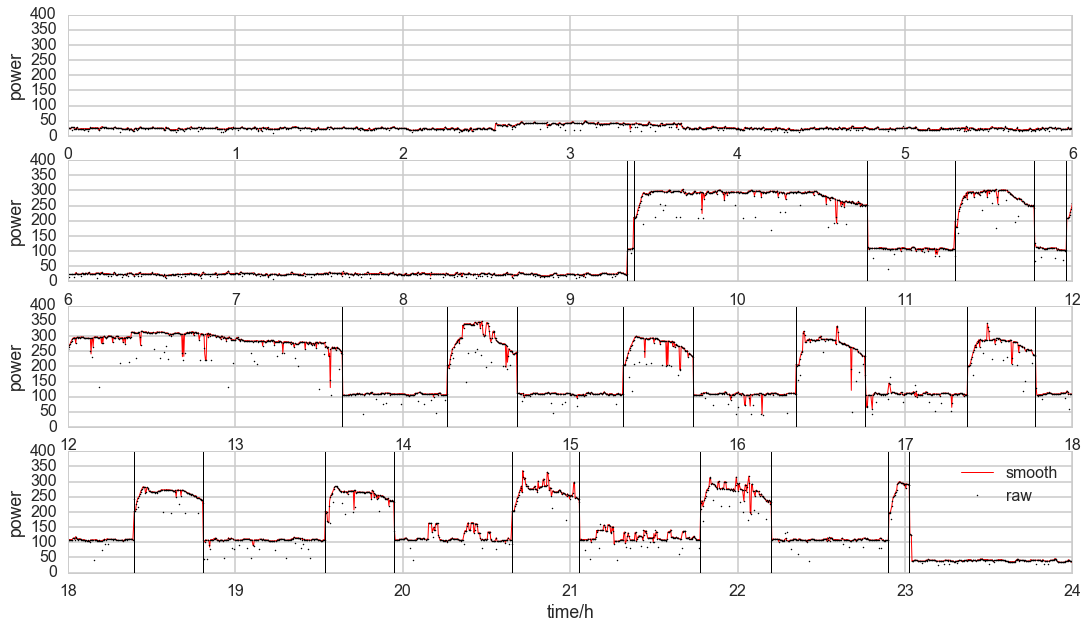

In [174]:
%%time
t, raw_data = bcp.read_dat_0819(datetime.date(2016,6,2), 0, 24, '../new_data/IHG')
if t[0]==t[1]:
    t = t[::2]
    raw_data = raw_data[::2]

_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

cp_list = bcp.disaggregate(data, para)
plot_24h_data(t, raw_data, data, cp_list)

print cp_list

In [172]:
%%time
t, raw_data = bcp.read_dat_0819(datetime.date(2016,7,2), 0, 24, '../new_data/IHG')
if t[0]==t[1]:
    t = t[::2]
    raw_data = raw_data[::2]

_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

cp_list = bcp.disaggregate(data, para)
# plot_24h_data(t, raw_data, data, cp_list)

# print cp_list

CPU times: user 5.23 s, sys: 54.9 ms, total: 5.29 s
Wall time: 5.41 s


[0, 3, 230, 879, 1261, 1269, 1277, 2845, 3268, 3276, 3320, 4017, 4460, 4484, 4492]
CPU times: user 5.02 s, sys: 54.3 ms, total: 5.08 s
Wall time: 5.06 s


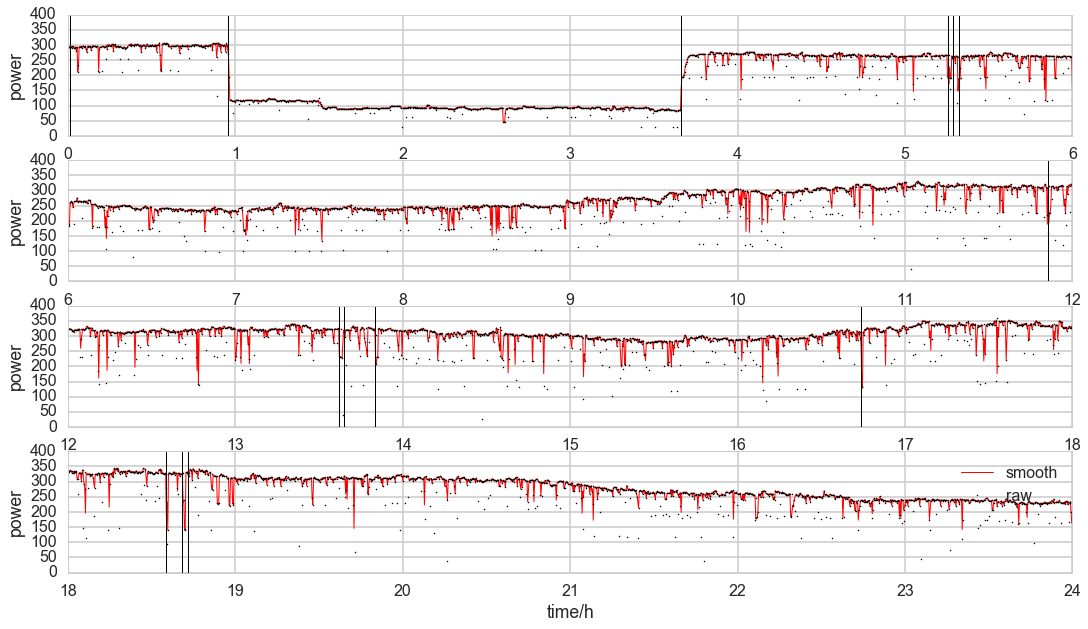

In [176]:
%%time
t, raw_data = bcp.read_dat_0819(datetime.date(2016,7,2), 0, 24, '../new_data/IHG_2/')
if t[0]==t[1]:
    t = t[::2]
    raw_data = raw_data[::2]

_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

cp_list = bcp.disaggregate(data, para)
plot_24h_data(t, raw_data, data, cp_list)

print cp_list

[0]
CPU times: user 4.94 s, sys: 66.8 ms, total: 5.01 s
Wall time: 5.03 s


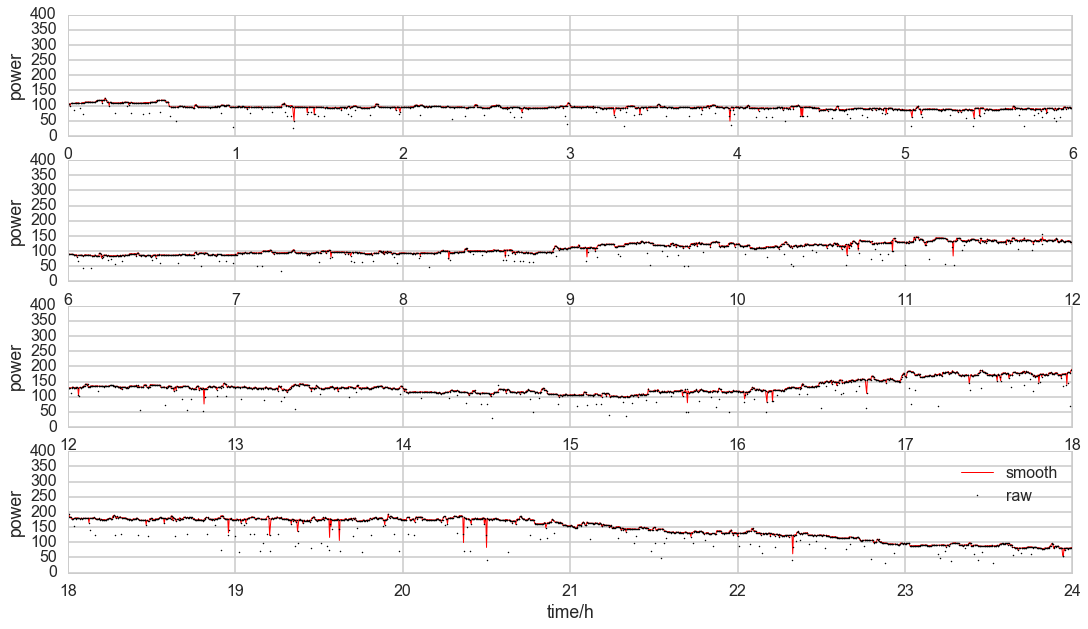

In [177]:
%%time
t, raw_data = bcp.read_dat_0819(datetime.date(2016,7,12), 0, 24, '../new_data/IHG_2/')
if t[0]==t[1]:
    t = t[::2]
    raw_data = raw_data[::2]

_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

cp_list = bcp.disaggregate(data, para)
plot_24h_data(t, raw_data, data, cp_list)

print cp_list

# 3. Run on all data to examine problems

In [184]:
# python run_all_data_0910.py
# see results/sep_10_result_**_**.jpg

# 4. Integrate into Viberbi method

[0, 3149, 3321, 3437, 3542, 3662, 3767, 3888, 3991, 4185, 5260, 5268]
CPU times: user 5.4 s, sys: 84.6 ms, total: 5.48 s
Wall time: 5.52 s


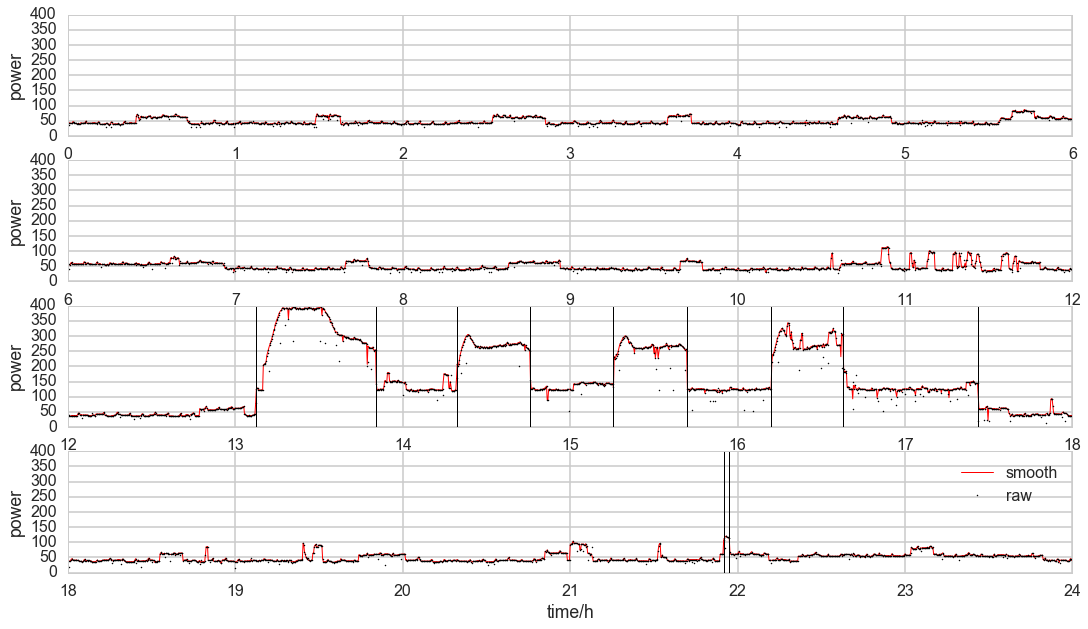

In [617]:
%%time
reload(bcp)
[t, raw_data] = bcp.read_dat_0910(datetime.datetime(2014,4,1), datetime.datetime(2014,4,2,0,0),  '../new_data/IHG/')
t_data = t

_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)

cp_list = bcp.disaggregate(data, para)

print cp_list

plot_24h_data(t, raw_data, data, cp_list)


In [619]:
# match each segment back to shape

data_seg = []
cp_list_2 = cp_list + [len(data)-1]
for i in range(1, len(cp_list_2)-1):
    cp_s = cp_list_2[i]
    cp_e = cp_list_2[i+1]
    if cp_e - cp_s > 50:
        cp_e = cp_s+50
    last_datum = np.mean( data[cp_s-3:cp_s] )
    data_seg.append([t-last_datum for t in data[cp_s:cp_e]])

n_seg = len( data_seg )
print 'n_seg', n_seg


n_seg 11


In [620]:
shape_matched = cluster_mean[0:2]
shape_matched.append(np.array([75 for _ in range(50)]) )

n_shape_matched = len(shape_matched)
n_shape_matched

3

In [621]:
# generate a dictionary of potential shapes and combined shapes

shape_dict = {}

all_shape_code = []
for shape_code in range(2**n_shape_matched):
    # generate which shape is used
    flag_shape_use = []
    for i_shape in range(n_shape_matched):
        flag_shape_use.insert(0, shape_code % 2)
        shape_code = shape_code/2
    final_shape = []
    for i_shape in range(n_shape_matched):
        if flag_shape_use[i_shape]:
            final_shape.append(shape_matched[i_shape])
    final_shape = np.sum(np.array(final_shape), axis=0)
    shape_dict[tuple(flag_shape_use)] = final_shape
    all_shape_code.append(tuple(flag_shape_use))
shape_dict[tuple(0 for _ in range(n_shape_matched))] = np.zeros(50)
all_shape_code

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

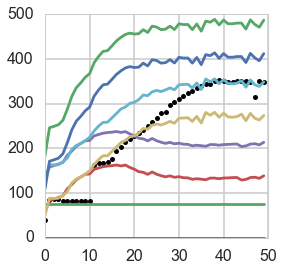

In [622]:
plt.figure(figsize=[4,4])
plt.plot(data_seg[0], 'ok', markersize=5, linewidth=1)
for t in all_shape_code:
    plt.plot(shape_dict[t])


In [623]:
def l2_distance(list_1, list_2, last_point_w = 50, n=2):
    dis = 0
    tmp = [(x-y)**n for x,y in zip(list_1, list_2)]
    dis = np.sum( tmp )
    if len(list_1) >= len(list_2):
        dis+=last_point_w*(list_1[-1] - list_2[-1])**n
    return dis / (len(tmp)+last_point_w)


In [624]:
# now for each segment, match to the shapes

shape_prob_list = []
var_measurement = 800

for i_seg, seg in enumerate(data_seg):
    distance_list = []
    distance_dict = {}
    seg_mean = np.mean(seg)
    
    for shape_code, shape in shape_dict.items():
        if seg_mean > 0:
            distance_dict[shape_code] = np.exp( -l2_distance(seg, shape) / var_measurement )
            distance_dict[tuple(-t for t in shape_code)] = 0            
        else:
            distance_dict[tuple(-t for t in shape_code)] = np.exp( -(shape[-1] - (-seg_mean))**2 / var_measurement )
            distance_dict[shape_code] = 0
    
    z = np.sum(distance_dict.values())
    distance_dict = {k:v/z for k,v in distance_dict.items()}
    
    shape_prob_list.append(distance_dict)
    
shape_prob_list[0]

{(-1, -1, -1): 0.0,
 (-1, -1, 0): 0.0,
 (-1, 0, -1): 0.0,
 (-1, 0, 0): 0.0,
 (0, -1, -1): 0.0,
 (0, -1, 0): 0.0,
 (0, 0, -1): 0.0,
 (0, 0, 0): 0.0,
 (0, 0, 1): 2.8683740301890945e-30,
 (0, 1, 0): 2.6517156882287985e-17,
 (0, 1, 1): 1.8797535020378873e-07,
 (1, 0, 0): 0.09474815313599777,
 (1, 0, 1): 0.90511163465655409,
 (1, 1, 0): 0.00014002423208720735,
 (1, 1, 1): 1.0660171327827791e-14}

In [625]:
n_equipment_type = 2
n_equipment = [1, 1]

obs_mat = np.array([ [1,1,0], [0,0,1] ])

# viterbi_algorithm

state_prob_list = {(0,0):.91, (0,1):0.03, (1,0):0.03, (1,1):0.03}

state_prob_list_list = [state_prob]
state_memory_list_list = []
shape_memory_list_list = []

for i_seg in range(n_seg):
    seg_mean = np.mean(data_seg[i_seg])
    
    next_state_prob_list = {t:0 for t in state_prob_list.keys()}
    state_memory_list = {t:0 for t in state_prob_list.keys()}
    shape_memory_list = {t:0 for t in state_prob_list.keys()}
    
    for next_state, next_state_prob in next_state_prob_list.items():

        max_prob = -float('Inf')
        max_past_state = tuple()
        max_shape = ()
        for shape_code, shape_prob in shape_prob_list[i_seg].items():
            change_state = np.dot(obs_mat, shape_code)
            past_state = tuple(np.subtract(next_state, change_state))
            if past_state in state_prob_list:
                if state_prob_list[past_state] * shape_prob > max_prob:
                    max_prob = state_prob_list[past_state] * shape_prob
                    max_past_state = past_state
                    max_shape = shape_code
        state_memory_list[next_state] = max_past_state
        next_state_prob_list[next_state] = max_prob
        shape_memory_list[next_state] = max_shape

    state_prob_list = next_state_prob_list
    
    state_prob_list_list.append(next_state_prob_list)
    state_memory_list_list.append(state_memory_list)
    shape_memory_list_list.append(shape_memory_list)
    

trace_list = []
shape_list = []

end_state = sorted(state_prob_list_list[-1].items(), key=operator.itemgetter(1))[-1][0]
trace_list.insert(0, end_state)

for i in reversed(range(n_seg)):
    max_shape = shape_memory_list_list[i][end_state]
    end_state = state_memory_list_list[i][end_state]
    trace_list.insert(0, end_state)
    shape_list.insert(0, max_shape)

print 'starting', trace_list[0]
for i in range(0, len(shape_list)):
    print 'through', shape_list[i], 'become', trace_list[i+1]



starting (0, 0)
through (1, 0, 1) become (1, 1)
through (0, -1, 0) become (0, 1)
through (0, 1, 0) become (1, 1)
through (0, -1, 0) become (0, 1)
through (0, 1, 0) become (1, 1)
through (0, -1, 0) become (0, 1)
through (0, 1, 0) become (1, 1)
through (0, -1, 0) become (0, 1)
through (0, 0, -1) become (0, 0)
through (0, 0, 1) become (0, 1)
through (0, 0, -1) become (0, 0)


In [626]:
# Dissaggregation

def generate_predicted_profile(cp_list, shape_matched, shape_list, raw_data, n_equipment_type, obs_mat, trace_list):

    predicted_profile = [ [] for _ in range(n_equipment_type+1) ]
    
    predicted_profile[n_equipment_type].extend( [raw_data[0] for _ in range(len(raw_data))] )
    
    for i_equipment in range(n_equipment_type):
        for i_cp in range(len(cp_list)):
            t_start = cp_list[i_cp]
            if i_cp == len(cp_list)-1:
                t_end = len(raw_data)
            else:
                t_end = cp_list[i_cp+1]
            if trace_list[i_cp][i_equipment] == 0:
                predicted_profile[i_equipment].extend([0 for _ in range(t_end-t_start)])
            else:
                if i_cp == 0 or (trace_list[i_cp][i_equipment] == trace_list[i_cp-1][i_equipment]):
                    if i_cp == 0:
                        last_datum = 0
                    else:
                        last_datum = predicted_profile[i_equipment][-1]
                    predicted_profile[i_equipment].extend([last_datum for _ in range(t_end-t_start)])
                else:
                    change_profile = []
                    for i_shape in range(len(shape_list[0])):
                        if shape_list[i_cp-1][i_shape] > 0 and obs_mat[i_equipment][i_shape] > 0:
                            change_profile.append(shape_matched[i_shape])
                    if len(change_profile) > 1:
                        change_profile = np.sum(change_profile, axis=0)
                    change_profile = change_profile[0]
                    if (t_end-t_start) > len( shape_matched[i_shape] ):
                        predicted_profile[i_equipment].extend( list(change_profile) )
                        predicted_profile[i_equipment].extend( [change_profile[-1] for _ in range(t_end-t_start-len( shape_matched[i_shape] ))] )
                    else:
                        predicted_profile[i_equipment].extend( change_profile[:t_end-t_start] )
                   
    power_sum = np.sum(predicted_profile, axis=0)
    predicted_profile_2 = [np.multiply(raw_data, np.divide(t, power_sum)) for t in predicted_profile]
    
    return predicted_profile_2
    
predicted_profile = generate_predicted_profile(cp_list, shape_matched, shape_list, raw_data, n_equipment_type, obs_mat, trace_list)
    

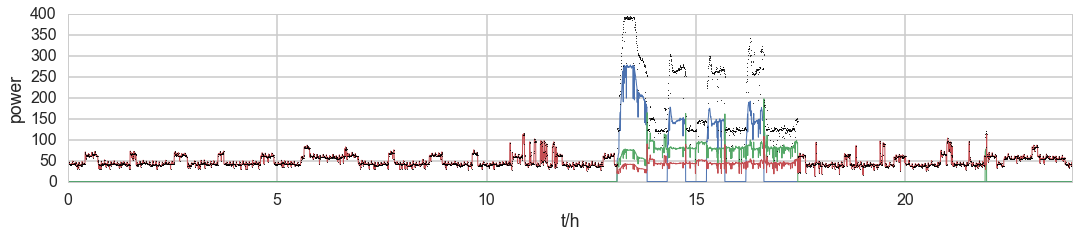

In [634]:
plt.figure(figsize=[18,3])
for tmp in predicted_profile:
    plt.plot(t_data, tmp, linewidth=1)
plt.plot(t_data, raw_data, 'k.', markersize=2)

plt.xlim([0,24])
plt.xlabel('t/h')
plt.ylabel('power')

In [629]:
np.sum(predicted_profile, axis=1)/np.sum(predicted_profile)

array([ 0.18838596,  0.1867732 ,  0.62484084])

# 5. Design proper API for the disaggregation package